In [6]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table
from tqdm.notebook import tqdm
from matplotlib.animation import FuncAnimation
from scipy.linalg import expm
import pandas as pd
from scipy.integrate import solve_ivp

resol = 200
pi = np.pi
version_table()

Software,Version
QuTiP,5.1.1
Numpy,1.26.2
SciPy,1.11.3
matplotlib,3.7.3
Number of CPUs,11
BLAS Info,Generic
IPython,8.17.2
Python,"3.12.0 (v3.12.0:0fb18b02c8, Oct 2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
Cython,3.0.11


<h1> State update </h1>

In [43]:
def update_state(c,b,g_0_matrix,omega_tab,omega_A,t, dt):
    """
    Update the state of the system based on the given parameters.
    
    Parameters:
    c (np array): Coefficients in front of the states |1_k, 0>
    b (np array): Atomic coefficient in front of the state |0, 1_j>
    g_0 (float): Coupling strength.
    omega_tab (array): Array of frequencies.
    L (int): Length of the system.
    
    Returns:
    c_new (np array): Updated coefficients.
    b_new (np array): Updated atomic coefficients.
    """
    n_A = g_0_matrix.shape[1]
    g_matrix = np.zeros_like(g_0_matrix)
    for i in range(n_A):
        g_matrix[:,i] = g_0_matrix[:,i] * np.exp(-1j * (omega_tab - omega_A) * t)


    b_new = c @ g_matrix
    c_new = np.conjugate(g_matrix) @ b

    return -1j* dt * c_new, -1j * dt * b_new

<h1> RG Scheme </h1>

In [23]:
def RG_scheme(c_init, b_init, g_0_matrix, omega_tab, omega_A, T, dt, progress_bar=True):
    """
    Propagates the state of the system using the RG scheme.
    
    Parameters:
    c_init (np array): initial coefficients in front of the states |1_k, 0>
    b_init (np array): initial atomic coefficient in front of the state |0, 1_j>
    g_0 (float): Coupling strength.
    omega_tab (array): Array of frequencies.
    L (float): Length of the system.
    T (float): Total time for propagation.
    dt (float): Time step for propagation.
    
    Returns:
    c_array (np array): Array of c coefficients at each time step.
    b_array (np array): Array of b coefficients at each time step.
    """

    nb_pts_time = int(T / dt)
    n_modes = len(c_init)
    n_A = len(b_init)
    c_array = np.zeros((nb_pts_time, n_modes), dtype=complex)
    b_array = np.zeros((nb_pts_time,n_A), dtype=complex)

    # Set the initial conditions
    c_array[0] = c_init
    b_array[0] = b_init

    # Time evolution loop
    for i in tqdm(range(1, nb_pts_time), disable=not progress_bar):
        t = i * dt
        c_current = c_array[i-1]
        b_current = b_array[i-1]

        c_new_k1, b_new_k1 = update_state(c_current, b_current, g_0_matrix, omega_tab, omega_A, t, dt)
        c_new_k2, b_new_k2 = update_state(c_current + c_new_k1/2, b_current + b_new_k1/2, g_0_matrix, omega_tab, omega_A, t + dt/2, dt)
        c_new_k3, b_new_k3 = update_state(c_current + c_new_k2/2, b_current + b_new_k2/2, g_0_matrix, omega_tab, omega_A, t + dt/2, dt)
        c_new_k4, b_new_k4 = update_state(c_current + c_new_k3, b_current + b_new_k3, g_0_matrix, omega_tab, omega_A, t + dt, dt)

        c_new = c_current + (c_new_k1 + 2*c_new_k2 + 2*c_new_k3 + c_new_k4) / 6
        b_new = b_current + (b_new_k1 + 2*b_new_k2 + 2*b_new_k3 + b_new_k4) / 6

        c_array[i] = c_new
        b_array[i] = b_new

    return c_array, b_array 
    

<h1> Function that treats the whole evolution </h1>

In [162]:
def get_data_mirror_fast(L, T, dt, omega_0, omega_A, position_atom_tab, omega_max, g_0, sigma, x_0, print_nb_modes = False, progress_bar=True):
    """
    Generate data for the RG scheme with a mirror.
    
    Parameters:
    L (float): Length of the system.
    T (float): Total time for propagation.
    dt (float): Time step for propagation.
    omega_0 (float): Frequency of the photon
    omega_A (float): Frequency of the atoms
    omega_max (float): Maximum frequency for the modes.
    g_0 (float): Coupling strength.
    sigma (float): Width of the Gaussian wave packet in position space.
    x_0 (float): Position of the Gaussian peak.
    print_nb_modes (bool): Whether to print the number of modes used.
    
    Returns:
    c_array (np array): Coefficients in front of the states |1_k, 0>.
    b_array (np array): Coefficients in front of the state |0, 1>.
    omega_tab (np array): Array of frequencies.
    """
    
    #quantization of the modes
    k_coord_tab_p = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    k_coord_tab = np.concatenate((-k_coord_tab_p,k_coord_tab_p))
    kx, ky = np.meshgrid(k_coord_tab, k_coord_tab, indexing="ij")
    k_tab = (kx + 1j*ky)[np.sqrt(kx**2 + ky**2) <= omega_max]
    omega_tab = np.abs(k_tab)
    n_modes = len(omega_tab)

    if print_nb_modes:
        print("Number of modes: ", n_modes)

    #create the coupling matrix at initial time
    g_0_matrix = 1j*g_0 * np.sqrt(omega_A) / L * np.exp(-1j * np.real(k_tab[:, np.newaxis] * np.conjugate(position_atom_tab)[np.newaxis, :]))


    #prepare the initial state
    print("Preparing the initial state...")
    n_A = position_atom_tab.shape[0]
    c_init = np.zeros(n_modes, dtype=complex)
    b_init = np.zeros(n_A, dtype=complex)

    k_0_vec = omega_0 + 0*1j

    c_init = np.exp(-(0.5*np.abs(k_tab - k_0_vec)**2) * sigma**2) * np.exp(-1j * 0.5 * np.real(k_tab * np.conjugate(x_0)))
    c_init /= np.sqrt(np.sum(np.abs(c_init)**2))  # Normalize the initial state

    ##evolve the state
    print("Evolving the state...")
    c_array, b_array = RG_scheme(c_init, b_init, g_0_matrix, omega_tab, omega_A, T, dt, progress_bar=progress_bar)

    return c_array, b_array, k_tab

<h1> First test </h1>

In [168]:
L = 10*pi
T = L/2
dt = 0.01

#Jaynes-Cummings parameter g_0 and energies 
g_0 = 1
omega_A = 3
omega_0 = 3
omega_max = 10

#initial photon wavepacket parameters
sigma = L/16
sigma_momentum = 1/sigma
x_0 = -L/4 + 0*1j

#prepare the position of the atoms
n_A = 49
position_atom_tab = np.zeros(n_A, dtype = complex)
spacing_atom = L / 64
for i in range(1, n_A//2+1):
    position_atom_tab[n_A//2 - i] = -i*spacing_atom - 1j*i*spacing_atom
    position_atom_tab[n_A//2 + i] = i*spacing_atom + 1j*i*spacing_atom


Check the initial configuration of the atoms

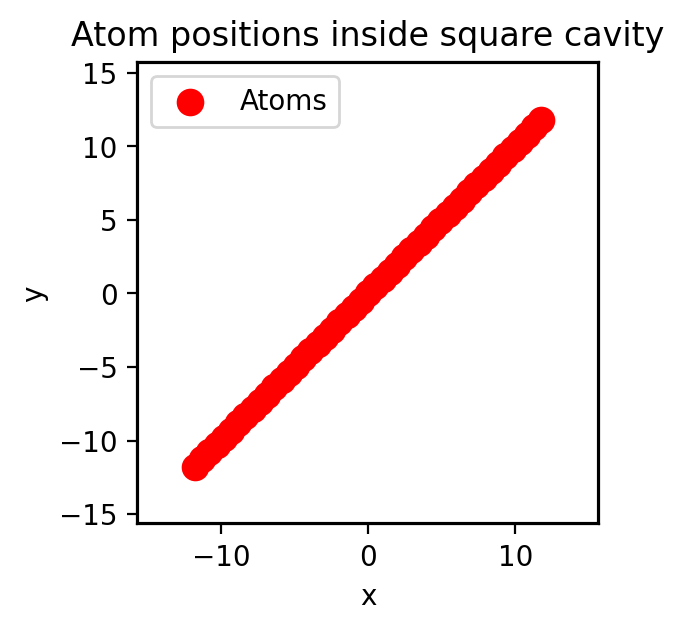

In [169]:
# extract coordinates
x_atoms = position_atom_tab.real
y_atoms = position_atom_tab.imag

# create plot
fig, ax = plt.subplots(figsize=(3, 3), dpi=resol)

# draw square centered at 0
halfL = L/2
square = plt.Rectangle((-halfL, -halfL), L, L, fill=False, color="black", linewidth=1.5)
ax.add_patch(square)

# plot atoms
ax.scatter(x_atoms, y_atoms, color="red", s=80, label="Atoms")

# formatting
ax.set_xlim(-halfL, halfL)
ax.set_ylim(-halfL, halfL)
ax.set_aspect("equal", "box")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
ax.set_title("Atom positions inside square cavity")

plt.show()

In [170]:
c_array, b_array, k_tab = get_data_mirror_fast(L, T, dt, omega_0, omega_A, position_atom_tab, omega_max, g_0, sigma, x_0, print_nb_modes = False, progress_bar=True)

Preparing the initial state...
Evolving the state...


  0%|          | 0/1569 [00:00<?, ?it/s]

<h1> Analysis of the data ? </h1>

First, check the excitation probability of the mirror

In [166]:
nb_pts_time = int(T/dt)
time_array = np.linspace(0, T, int(T / dt))
p_A_tab = np.zeros(nb_pts_time)
p_1_tab = np.zeros(nb_pts_time)
p_2_tab = np.zeros(nb_pts_time)

for i in tqdm(range(nb_pts_time)):
    p_A_tab[i] = np.sum(np.abs(b_array[i])**2)
    p_1_tab[i] = np.sum(np.abs(c_array[i][np.real(k_tab) >= np.imag(k_tab)])**2)
    p_2_tab[i] = np.sum(np.abs(c_array[i][np.real(k_tab) < np.imag(k_tab)])**2)

  0%|          | 0/1570 [00:00<?, ?it/s]

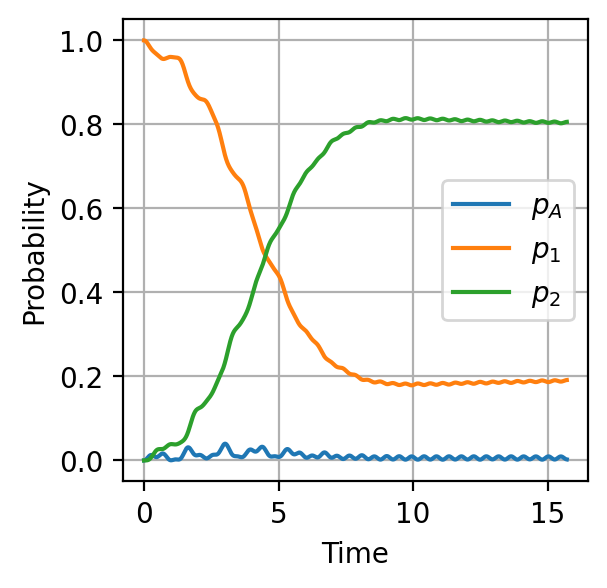

In [167]:
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
ax.plot(time_array, p_A_tab, label=r"$p_A$")
ax.plot(time_array, p_1_tab, label=r"$p_1$")
ax.plot(time_array, p_2_tab, label=r"$p_2$")
ax.set_xlabel("Time")
ax.set_ylabel("Probability")
ax.legend()
ax.grid()
plt.show()